# Week4授業課題 信用情報の学習

## 1.このテキストについて

### テキストの目的
実データに近いものに対して機械学習を行う

### どのように学ぶか
Kaggleのデータセットを通じて、機械学習の基本的な流れやライブラリの使い方を学びます。

## 2.信用情報


Kaggleの Home Credit Default Risk コンペティションの学習および推定を行います。

Home Credit Default Risk | Kaggle

## 【問題1】コンペティション内容の確認
コンペティションのOverviewページ読み、「Home Credit Default Risk」について以下の観点について確認してください。

- 何を学習し、何を予測するのか
- どのようなファイルを作りKaggleに提出するか
- 提出されたものはどういった指標値で評価されるのか

### 【回答】
- 何を学習し、何を予測するのか
  - クライアントの性別・家族有無・年収やローン与信額などの変数を学習し、返済能力の有無を予測する。
  - ターゲット変数
    - 1:支払が困難なクライアント：彼/彼女は私たちのサンプル、
    - 0:ローンの最初のYの分割払いの少なくとも一方にX日以上延滞していた - 他のすべての場合
- どのようなファイルを作りKaggleに提出するか
  - SK_ID_CURR、	TARGETの2カラムを用意してcsv形式で提出
- 提出されたものはどういった指標値で評価されるのか
  - 予測値の対数と観測された販売価格の対数との間のRoot-Mean-Squared-Error（RMSE）で評価されます。（ログを取ることは、高価な家と安い家を予測する際のエラーが結果に等しく影響することを意味します。）

## 3.ベースラインモデルの作成

まずは単純な方法による ベースラインモデル　を作成します。精度の基準となるモデルです。

精度を高くする必要はありません。エラーなく実行でき、Kaggle側に推定値を提出できることを目指します。

## 【問題2】学習と検証
データを簡単に分析、前処理し、学習、検証するまでの一連の流れを作成・実行してください。

検証にはこのコンペティションで使用される評価指標を用いるようにしてください。学習に用いる手法は指定しません。

### ■ライブラリインポート

In [1]:
# Numpy
import numpy as np
import numpy.random as random

# Dataframe operations
import pandas as pd

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Scalers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Data Split
from sklearn.model_selection import train_test_split

# Cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit

# Linear-models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.svm import LinearSVC

# Dicision Tree
# import pydotplus
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import datasets
from IPython.display import Image

# Random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn import metrics
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import precision_score
# from sklearn.metrics import recall_score
# from sklearn.metrics import f1_score
# from sklearn.metrics import classification_report
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import roc_curve
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import auc

# Tuning parameters
from sklearn.model_selection import GridSearchCV

random.seed(0)

### ■データの取得・確認

In [2]:
# トレーニングデータの取得
df = pd.read_csv("../../data/home-credit-default-risk/application_train.csv")
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# テストデータの取得
df_test = pd.read_csv("../../data/home-credit-default-risk/application_test.csv")
df_test02 = df_test.copy()
df_test03 = df_test.copy()
df_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [5]:
# 欠損値の確認
def missing_data(df):
    total = pd.DataFrame(df.isnull().sum().sort_values(ascending = False), columns=['Total'])
    total = total[total['Total'] > 0]
    total['Percent'] = total['Total']/df.shape[0] * 100
    return total

missing_data(df)

,Total,Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
...,...,...
EXT_SOURCE_2,660,0.214626
AMT_GOODS_PRICE,278,0.090403
AMT_ANNUITY,12,0.003902
CNT_FAM_MEMBERS,2,0.000650


In [6]:
# データタイプの確認
df.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

### ■カテゴリ変数の置換
一旦全てのカテゴリ変数を数値へ変換する。このとき、nullは新たなカテゴリとして数値を代入する。

例）ある変数にnan, a, b というデータがあるとき、それぞれを0, 1, 2へ変換する。

In [7]:
# 全変全一括変換用関数
def dummy_variable_all(df, sort_frequence=True, dropna=True, map_show=False, skip_column=[]):
    """
    オブジェクト型の変数を数値へ一括変換する処理。
    
    Parameters
    ----------------
    df : pd.DataFrame
      データセットのDataFrame。
    sort_frequence : bool
      数値変換の順番を頻度順にするか
    dropna : bool
      nullを同様に数値へ変換するか
    map_show : bool
      変換するname mapを標準出力するか

    Returns
    ----------------
    df : pd.DataFrame
    """
    
    for column_name in df:
        if np.dtype(df[column_name]) == 'object' and column_name not in skip_column:
            if sort_frequence:
                unique_value = df[column_name].value_counts(dropna=dropna).sort_values(ascending=False).index
            else:
                unique_value = df[column_name].value_counts(dropna=dropna).sort_index().index

            name_map = {}
            for i, value in enumerate(unique_value):
                name_map[value] = i
            if map_show:
                print('column_name :', column_name)
                print('replace :', name_map)
            df[column_name] = df[column_name].map(name_map)
        else:
            pass
    return df

In [8]:
print("カテゴリ変数を以下のように置換")
df2 = dummy_variable_all(df.copy(), dropna=False, map_show=True)

カテゴリ変数を以下のように置換
column_name : NAME_CONTRACT_TYPE
replace : {'Cash loans': 0, 'Revolving loans': 1}
column_name : CODE_GENDER
replace : {'F': 0, 'M': 1, 'XNA': 2}
column_name : FLAG_OWN_CAR
replace : {'N': 0, 'Y': 1}
column_name : FLAG_OWN_REALTY
replace : {'Y': 0, 'N': 1}
column_name : NAME_TYPE_SUITE
replace : {'Unaccompanied': 0, 'Family': 1, 'Spouse, partner': 2, 'Children': 3, 'Other_B': 4, nan: 5, 'Other_A': 6, 'Group of people': 7}
column_name : NAME_INCOME_TYPE
replace : {'Working': 0, 'Commercial associate': 1, 'Pensioner': 2, 'State servant': 3, 'Unemployed': 4, 'Student': 5, 'Businessman': 6, 'Maternity leave': 7}
column_name : NAME_EDUCATION_TYPE
replace : {'Secondary / secondary special': 0, 'Higher education': 1, 'Incomplete higher': 2, 'Lower secondary': 3, 'Academic degree': 4}
column_name : NAME_FAMILY_STATUS
replace : {'Married': 0, 'Single / not married': 1, 'Civil marriage': 2, 'Separated': 3, 'Widow': 4, 'Unknown': 5}
column_name : NAME_HOUSING_TYPE
replace : {'Hous

In [9]:
df2.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,1,0,0,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,0,0,1,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,1,1,0,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,0,0,0,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,1,0,0,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# 置換後のデータタイプ確認
df2.dtypes.value_counts()

float64    65
int64      57
dtype: int64

### ■int型, float型の欠損値の分布の確認
欠損のある変数の箱ひげ図・バイオリン図を一括表示して分布を確認する。

In [11]:
# 箱ひげ図、バイオリン図一括表示
def box_violin(df, box=True, violin=True):
    
    n2 = 5
    n1 = int(np.ceil(df.shape[1]/n2))
    
    fig, axes = plt.subplots(n1, n2, figsize=(15, n1*4))
    ax = axes.ravel()
        
    for i, column_name in enumerate(df):
        # 箱ひげ図表示
        if box:
            ax[i].boxplot(df[column_name].dropna())
        # バイオリン図表示
        if violin:
            ax[i].violinplot(df[column_name].dropna(), showmeans=True)
            
        # 欠損率算出
        n1 = df[column_name].dropna().shape[0]
        n2 = df[column_name].shape[0]
        missing_ratio = format(100 - (n1 / n2 * 100), '.2f')
        text = str(n1) + '/' + str(n2) + ' ' + str(missing_ratio) + '% missing'
        # グラフ設定
        ax[i].set_title(column_name)
        ax[i].set_xlabel(text)
        ax[i].xaxis.set_ticks([])
        ax[i].grid(True, alpha=0.6)
    
    ax[0].set_ylabel('value')
    plt.show()

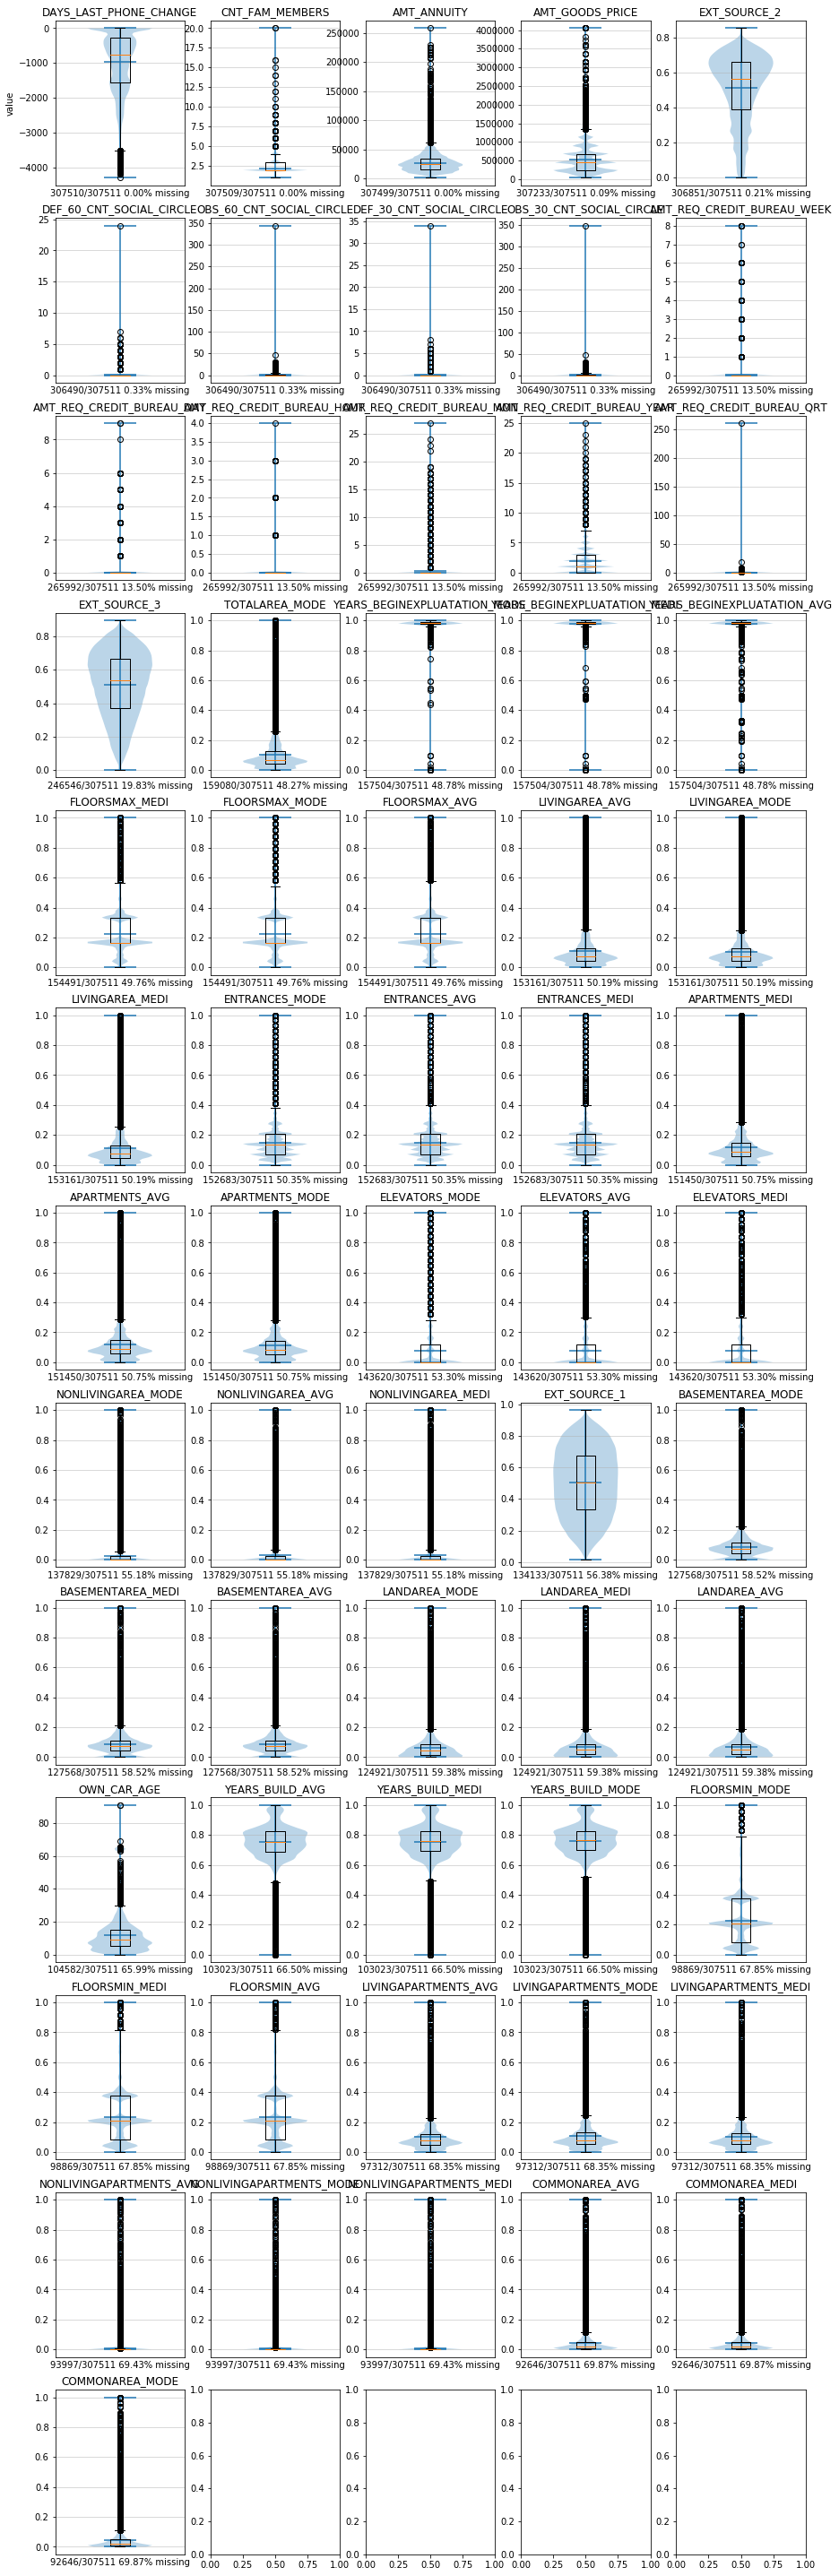

In [12]:
# 欠損のあるデータを取得
index = df2.isnull().sum().sort_values().loc[df2.isnull().sum() > 0].index

# グラフ表示
box_violin(df2.loc[:, index], box=True, violin=True)

全体的にテールの長いデータになっているため、欠損値を「中央値」で穴埋めする。

### ■int型・float型の欠損値を「中央値」で穴埋めする

In [13]:
df2.fillna(df2.median(), inplace=True)
df2.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,1,0,0,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,0,0,1,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,1,1,0,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,0,0,0,0,135000.0,312682.5,29686.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,100007,0,0,1,0,0,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# 欠損がないことを確認
missing_data(df2)

,Total,Percent


### ■モデル構築（ランダムフォレスト）
今後も活用できそうなため、モデル作成の一連の流れを関数化しておく。

In [15]:
def classification_model(df, 
                         y_column_name,
                         algorithm='LogisticRegression', 
                         test_size=0.3, 
                         random_state=0, 
                         standardization=False,
                         scaling_func=None,
                         roc=False, 
                         confusion=True, 
                         pos_label=None):
    
    # 使用可能なモデルのリスト
    algorithm_list = ['LogisticRegression',
                      'LinearSVC', 
                      'DecisionTreeClassifier',
                      'RandomForestClassifier']
    
    # 引数不正チェック
    assert algorithm in algorithm_list, "[ERROR] An invalid value is specified for the 'algorithm' parameter."
    assert roc or confusion, "[ERROR] Either 'roc' or 'confusion' parameter must be True."    
    
    # データを説明変数と目的変数へ分割
    x = df.drop(y_column_name, axis=1)
    y = df.loc[:, y_column_name]
    
    # ホールドアウト検証
    print('[INFO] Running train_test_spolit (test_size = {},  random_state = {})'.format(test_size, random_state))
    if random_state != None:
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)
    else:
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
        
    # スケーリング
    # カスタム
    if scaling_func != None:
        print('[INFO] Running custom scaling function...')
        scaling_func(x_train, x_test)
    
    # 標準化
    elif standardization:
        scaler = StandardScaler()
        scaler.fit(x_train)
        x_train = scaler.transform(x_train)
        x_test = scaler.transform(x_test)
    
    # クラス初期化
    if algorithm == algorithm_list[0]:
        model = LogisticRegression()
    elif algorithm == algorithm_list[1]:
        model = LinearSVC()
    elif algorithm == algorithm_list[2]:
        model = DecisionTreeClassifier()
    elif algorithm == algorithm_list[3]:
        model = RandomForestClassifier()
        
    # トレーニングデータで学習
    print('[INFO] Running ' + algorithm + '...')
    model.fit(x_train, y_train)
    print('[INFO]', model)
#     print(model)

    # 予測
    if roc:
        y_pred = model.predict_proba(x_test)
        y_pred_train = model.predict_proba(x_train)
    if confusion:
        y_pred = model.predict(x_test)
        y_pred_train = model.predict(x_train)
        
        
    # 評価
    # AUC・ROC曲線
    if roc:
        # AUC
        fpr, tpr, thres = metrics.roc_curve(y_test, y_pred[:, 1])
        auc = metrics.auc(fpr, tpr)
        score = auc
        print('[INFO] auc:', auc)
        # ROC曲線
        plt.figure(figsize = (5, 5), facecolor='w') #単一グラフの場合のサイズ比の与え方
        plt.plot(fpr, tpr, marker='o')
        plt.xlabel('FPR: False Positive Rete', fontsize = 13)
        plt.ylabel('TPR: True Positive Rete', fontsize = 13)
        plt.grid(True, alpha=.5)
        plt.show()
        
    # 精度表示と混同行列
    if confusion:
        def model_score(y, y_pred):
            # 精度を表示
            values = {'Accuracy ':0, 'Precision':0, 'Recall   ':0, 'F        ':0}
            if pos_label == None:
                values['Accuracy '] = metrics.accuracy_score(y, y_pred)   # Accuracy（正解率）
                values['Precision'] = metrics.precision_score(y, y_pred) # Precision（適合率）
                values['Recall   '] = metrics.recall_score(y, y_pred)       # Recall（再現率）
                values['F        '] = metrics.f1_score(y, y_pred)                # F値
            else:
                values['Accuracy '] = metrics.accuracy_score(y, y_pred)   # Accuracy（正解率）
                values['Precision'] = metrics.precision_score(y, y_pred, pos_label=pos_label) # Precision（適合率）
                values['Recall   '] = metrics.recall_score(y, y_pred, pos_label=pos_label)       # Recall（再現率）
                values['F        '] = metrics.f1_score(y, y_pred, pos_label=pos_label)                # F値  
            for key, value in values.items():
                print("{} : {:.3f}".format(key, value))
        print('\n[INFO] Training data accuracy')
        model_score(y_train, y_pred_train)
        print('\n[INFO] Test data accuracy')
        model_score(y_test, y_pred)
        
        # 混同行列を表示
        confusion_df = pd.DataFrame(confusion_matrix(y_test, y_pred), index=[0,1], columns=[0,1])
        plt.figure(figsize=(5, 3))
        sns.heatmap(confusion_df, cmap='Pastel1', cbar=False, annot_kws={"size": 22}, annot=True, fmt="d", linewidths=1)
        plt.title("Confusion-matrix", fontsize=14)
        plt.xlabel("Predicted value", fontsize=12)
        plt.ylabel("Observed value", fontsize=12)
        plt.show()
        
        
    # 重要度を抽出・可視化
    importances = model.feature_importances_
    ser_importances = pd.Series(importances, index=x_train.columns).sort_values(ascending=True)
    with plt.style.context('classic'):
        plt.figure(figsize=(12,int(df.shape[1]/4)), facecolor='w')
        plt.barh(ser_importances.index,
                 ser_importances,
                 align='center',
                 color='red',
                 alpha=.5
                )
        plt.title('Feature importances')
        plt.xlabel('Importances')
        plt.ylabel('Feature value')
        plt.grid(True)
        plt.show()

    return model, y_pred, ser_importances


[INFO] Running train_test_spolit (test_size = 0.3,  random_state = 0)
[INFO] Running RandomForestClassifier...
[INFO] RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
[INFO] auc: 0.7121698526972537


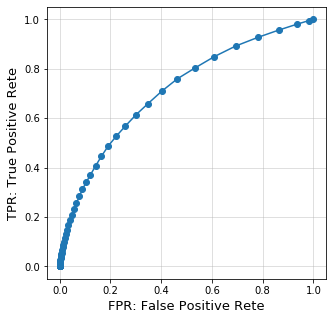

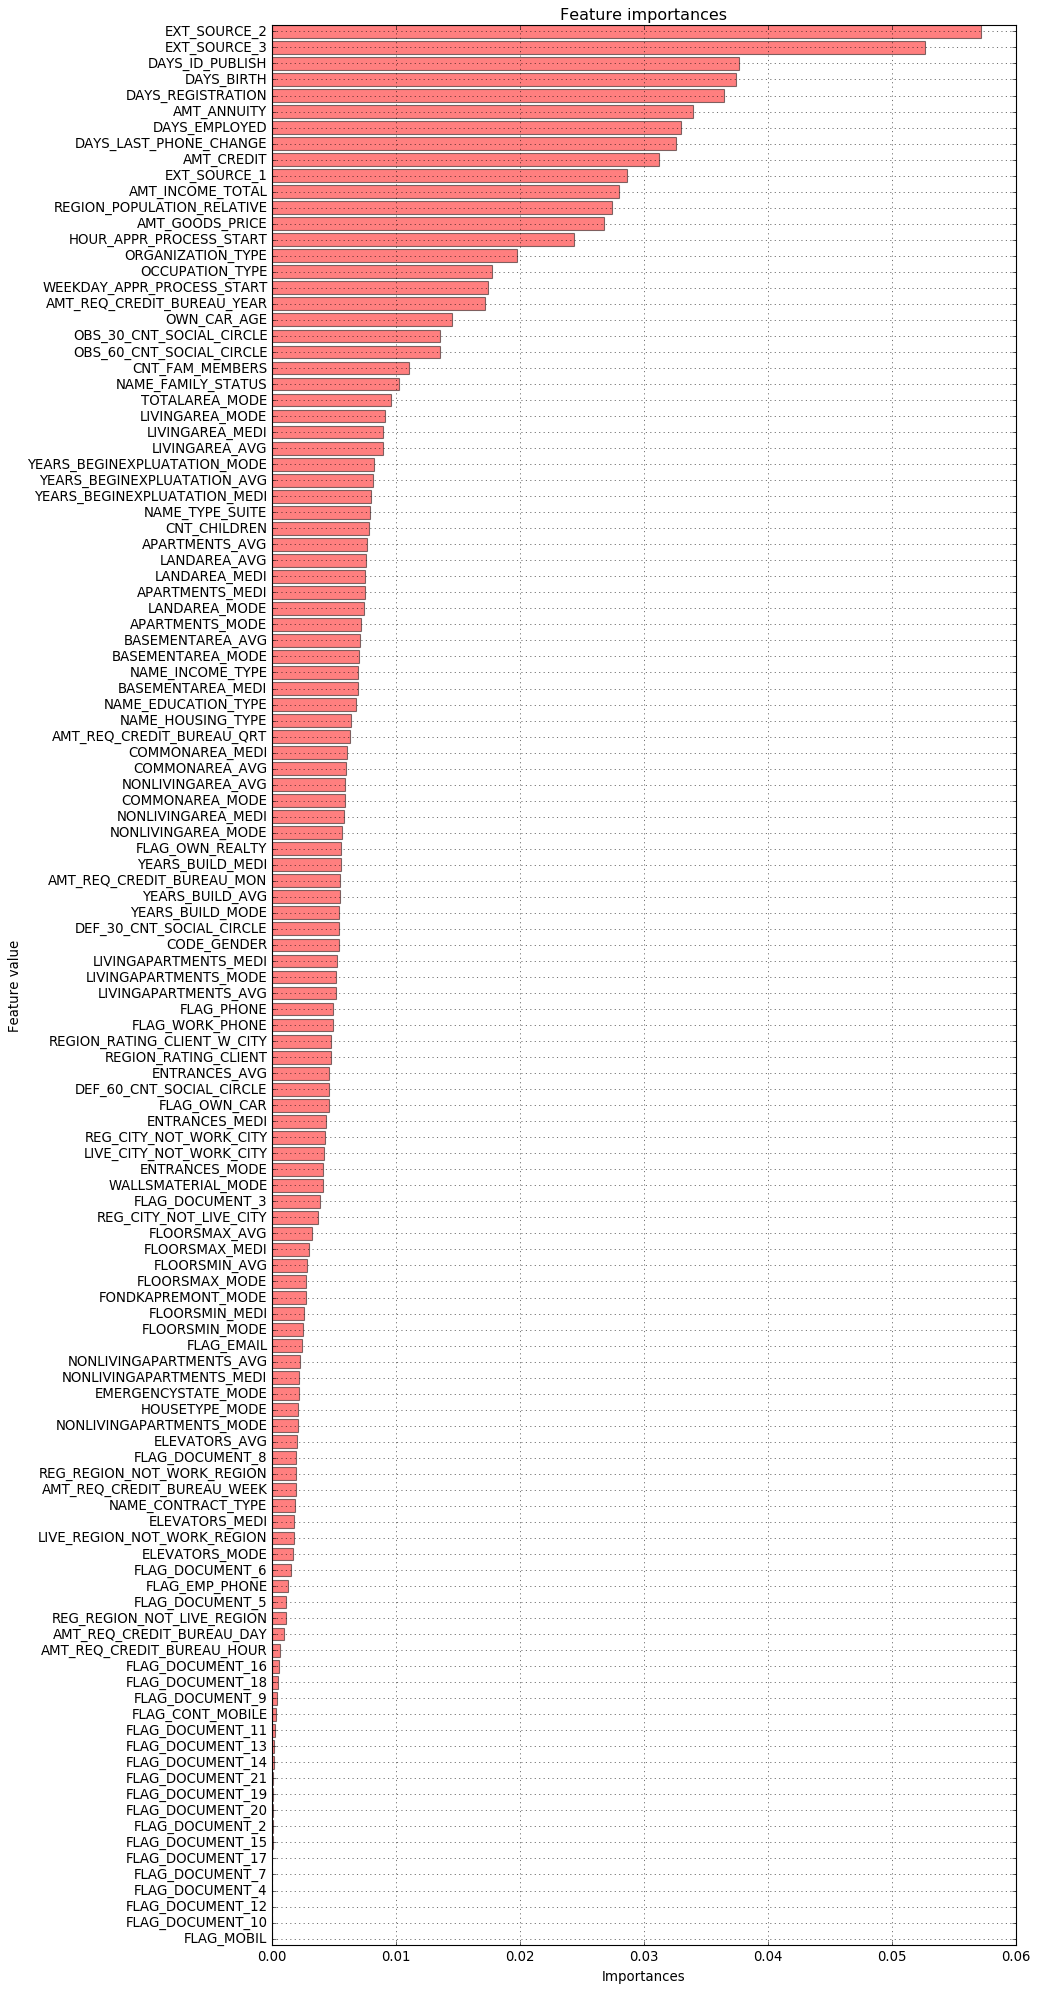

In [16]:
model01, y_pred01, importances01 = classification_model(df2.drop('SK_ID_CURR', axis=1), 
                                         'TARGET', 
                                         algorithm='RandomForestClassifier', 
                                         roc=True, 
                                         confusion=False,
                                         standardization=False)

### ■テストデータの用意
テストデータもトレーニングデータと同様のカテゴリ変数の置換・欠損値の中央値埋めを行う。

In [17]:
df_test = dummy_variable_all(df_test.copy(), dropna=False, map_show=False)
df_test.fillna(df_test.median(), inplace=True)
df_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,0,0,0,0,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,0,1,0,0,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,0,1,1,0,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,0,0,0,0,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,0,1,1,1,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


SK_ID_CURRのみ分割

In [18]:
df_test_id = df_test.loc[:, ['SK_ID_CURR']]
df_test_id.head()

,SK_ID_CURR
0,100001
1,100005
2,100013
3,100028
4,100038


In [19]:
df_test.drop('SK_ID_CURR', axis=1, inplace=True)
df_test.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,0,0,0,0,135000.0,568800.0,20560.5,450000.0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1,0,0,0,99000.0,222768.0,17370.0,180000.0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,0,1,1,0,0,202500.0,663264.0,69777.0,630000.0,3,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,0,0,0,0,2,315000.0,1575000.0,49018.5,1575000.0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,0,1,1,1,1,180000.0,625500.0,32067.0,625500.0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


### ■テストデータの予測実行

In [20]:
predict01 = model01.predict_proba(df_test)
predict01

array([[0.99, 0.01],
       [0.91, 0.09],
       [0.96, 0.04],
       ...,
       [0.94, 0.06],
       [0.92, 0.08],
       [0.79, 0.21]])

In [21]:
df_test_id['TARGET'] = predict01[:, 1]
df_test_id.head()

,SK_ID_CURR,TARGET
0,100001,0.01
1,100005,0.09
2,100013,0.04
3,100028,0.06
4,100038,0.06


### ■予測データをCSV出力

In [22]:
df_test_id.to_csv('./submission02.csv', index=False)

## 【問題3】テストデータに対する推定
テストデータ（application_test.csv）に対して推定を行い、Kaggleに提出を行ってください。

正しく提出が行えていれば、精度は低くても構いません。

### ■Kaggleへの提出結果
Private Score : 0.67469  

Public Score : 0.68721

## 4.特徴量エンジニアリング

ベースラインモデルを元に、入力する特徴量に様々な工夫を行い精度を向上させていきます。

## 【問題4】特徴量エンジニアリング
精度を上げるために以下のような観点で 特徴量エンジニアリング（Feature Engineering） を行ってください。

- どの特徴量を使うか
- どう前処理をするか

何をした時に検証データに対する評価指標がどのようになったかをまとめてください。最低5パターンの学習・検証を行ってください。

精度が高かったものに関してはテストデータに対しても推定を行い、Kaggleに提出を行ってください。

## ★★★★★★★★ パターン1 ★★★★★★★★

欠損の多い特徴量を除外して再学習・検証する。

### ■欠損が多かったデータを除外する
事前に表示していた箱ひげ図に表示していた欠損率を確認してみると、

欠損が「EXT_SOURCE_3の欠損率19.83%」の次が「TOTALAREA_MODEの欠損率48.27%」となっており、

ここを境に跳ね上がっているため、一旦このラインで切り取ってみる。

In [23]:
# dropするカラム名を取得
index.get_loc('EXT_SOURCE_3')
index.get_loc('TOTALAREA_MODE')
drop_index4_1 = index[index.get_loc('TOTALAREA_MODE'):]

In [24]:
df4_1 = df2.drop(drop_index4_1, axis=1).copy()
df4_1.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,1,0,0,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,0,0,1,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,1,1,0,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,0,0,0,0,135000.0,312682.5,29686.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,100007,0,0,1,0,0,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### ■dropした特徴量の重要度を確認する
重要度が高くても一旦はこのまま作業をすすめるが、重要度の高い特徴量があった場合は、次回以降で追加を検討する。

【確認結果】

下記の重要度がやや高め。その他は全て0.01より小さい。
- EXT_SOURCE_1 : 0.0278
- OWN_CAR_AGE : 0.0144

In [25]:
# dropする特徴量の重要度を確認
n = importances01.shape[0]+1
for column in enumerate(drop_index4_1):
    imp = importances01.loc[column[1]]
#     rank = importances01[importances01==column].index
    print('{} : {:.4f}'.format(column[1], imp))

TOTALAREA_MODE : 0.0096
YEARS_BEGINEXPLUATATION_MODE : 0.0082
YEARS_BEGINEXPLUATATION_MEDI : 0.0080
YEARS_BEGINEXPLUATATION_AVG : 0.0081
FLOORSMAX_MEDI : 0.0030
FLOORSMAX_MODE : 0.0028
FLOORSMAX_AVG : 0.0032
LIVINGAREA_AVG : 0.0089
LIVINGAREA_MODE : 0.0091
LIVINGAREA_MEDI : 0.0089
ENTRANCES_MODE : 0.0041
ENTRANCES_AVG : 0.0046
ENTRANCES_MEDI : 0.0044
APARTMENTS_MEDI : 0.0075
APARTMENTS_AVG : 0.0077
APARTMENTS_MODE : 0.0072
ELEVATORS_MODE : 0.0017
ELEVATORS_AVG : 0.0020
ELEVATORS_MEDI : 0.0018
NONLIVINGAREA_MODE : 0.0056
NONLIVINGAREA_AVG : 0.0059
NONLIVINGAREA_MEDI : 0.0058
EXT_SOURCE_1 : 0.0287
BASEMENTAREA_MODE : 0.0070
BASEMENTAREA_MEDI : 0.0069
BASEMENTAREA_AVG : 0.0071
LANDAREA_MODE : 0.0074
LANDAREA_MEDI : 0.0075
LANDAREA_AVG : 0.0076
OWN_CAR_AGE : 0.0145
YEARS_BUILD_AVG : 0.0055
YEARS_BUILD_MEDI : 0.0055
YEARS_BUILD_MODE : 0.0054
FLOORSMIN_MODE : 0.0025
FLOORSMIN_MEDI : 0.0026
FLOORSMIN_AVG : 0.0028
LIVINGAPARTMENTS_AVG : 0.0052
LIVINGAPARTMENTS_MODE : 0.0052
LIVINGAPARTMENTS_ME

### ■モデリング

[INFO] Running train_test_spolit (test_size = 0.3,  random_state = 0)
[INFO] Running RandomForestClassifier...
[INFO] RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
[INFO] auc: 0.7152312069996898


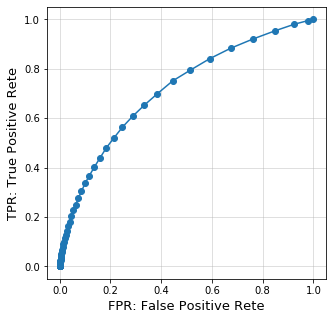

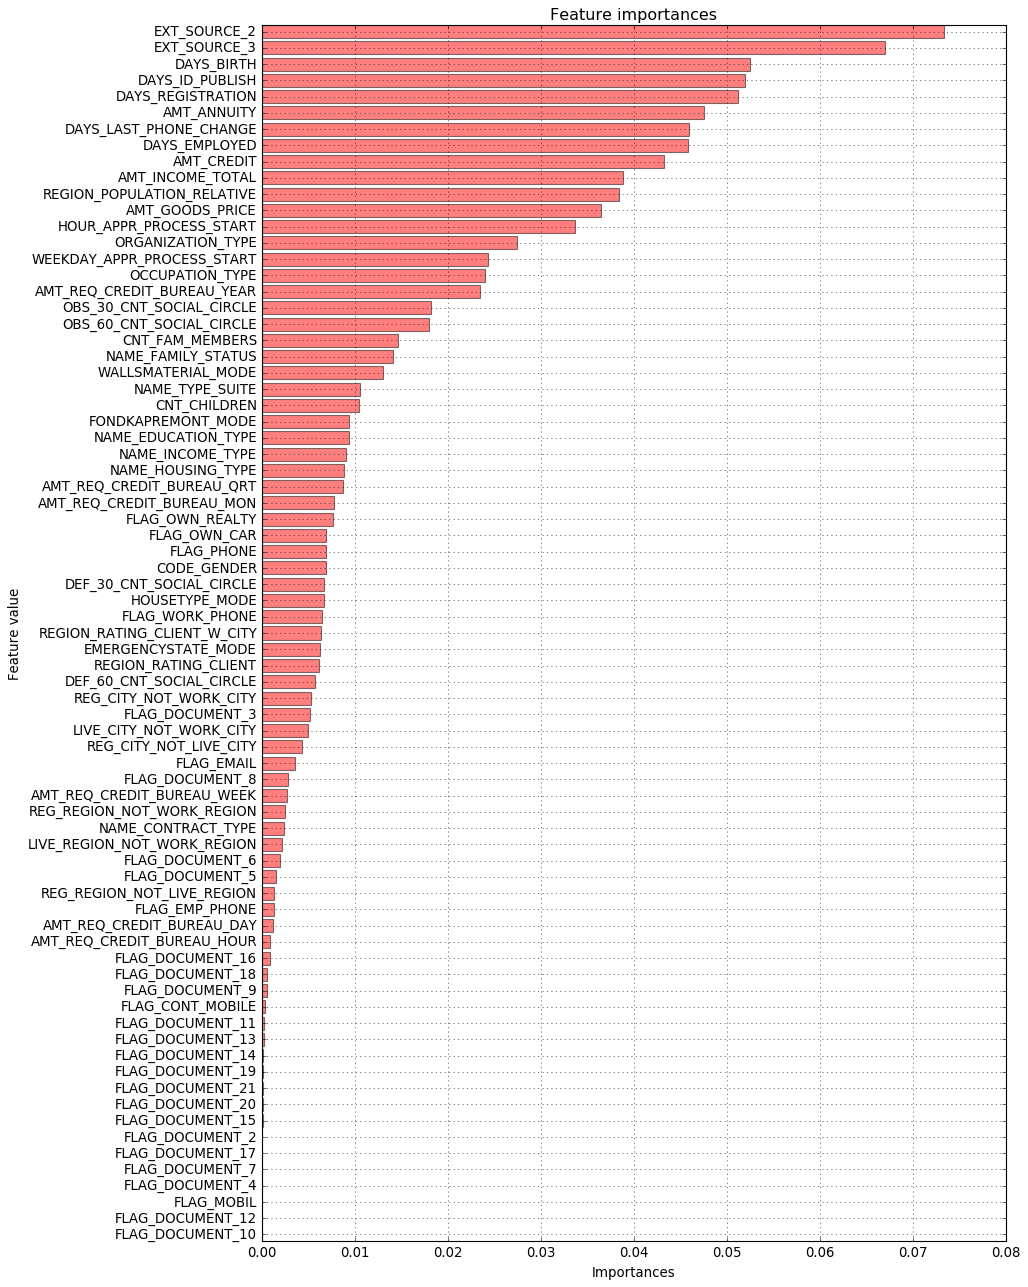

In [26]:
model02, y_pred02, importances02 = classification_model(df4_1.drop('SK_ID_CURR', axis=1), 
                                         'TARGET', 
                                         algorithm='RandomForestClassifier', 
                                         roc=True, 
                                         confusion=False,
                                         standardization=False)

## ■パターン1の結論
実行毎に誤差はあるが、最初のベースラインモデルから精度は変わっていないように見受けられる。

## ★★★★★★★★ パターン2 ★★★★★★★★

パターン1に、比較的重要度の高かったEXT_SOURCE_1、OWN_CAR_AGEを追加して再実行

In [27]:
df4_2 = df4_1.copy()
df4_2['EXT_SOURCE_1'] = df2['EXT_SOURCE_1']
df4_2['OWN_CAR_AGE'] = df2['OWN_CAR_AGE']

[INFO] Running train_test_spolit (test_size = 0.3,  random_state = 0)
[INFO] Running RandomForestClassifier...
[INFO] RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
[INFO] auc: 0.7195975472924393


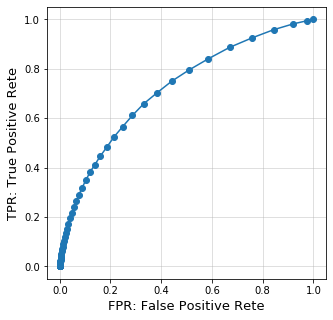

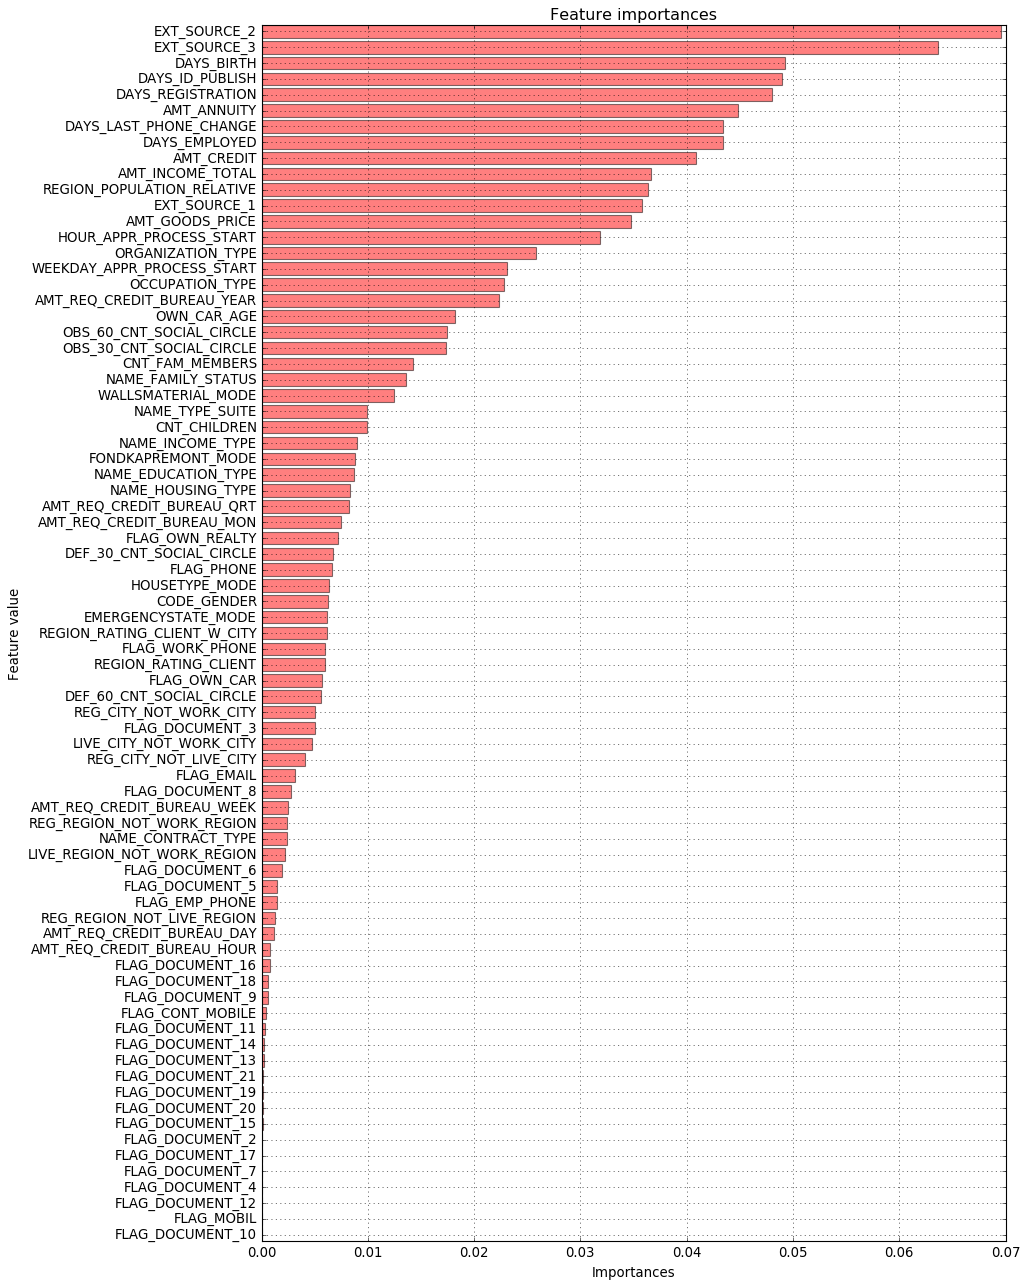

In [28]:
model03, y_pred03, importances03 = classification_model(df4_2.drop('SK_ID_CURR', axis=1), 
                                         'TARGET', 
                                         algorithm='RandomForestClassifier', 
                                         roc=True, 
                                         confusion=False,
                                         standardization=False)

## ■パターン2の結論
random_stateを変更して複数回実行してみたところ、やや(0.01前後)AUCが上昇したように見受けられる。

## ★★★★★★★★ パターン3 ★★★★★★★★
欠損は関係なく、ベースラインモデル実行時の重要度の累計値が上位N%の特徴量のみで実行

※Nの値は変えて複数回実行

In [29]:
# 重要度上位80%の変数名を抽出
imp_ruikei80 = np.cumsum(importances01.sort_values(ascending=False))
print(imp_ruikei80)
cut_ratio = 0.96
imp_ruikei80_index = list(imp_ruikei80[imp_ruikei80 <= cut_ratio].index)
imp_ruikei80_index.append('SK_ID_CURR')
imp_ruikei80_index.append('TARGET')
print(imp_ruikei80_index)
df4_3 = df2.loc[:, imp_ruikei80_index].copy()
df4_3.head()

EXT_SOURCE_2         0.057158
EXT_SOURCE_3         0.109817
DAYS_ID_PUBLISH      0.147460
DAYS_BIRTH           0.184890
DAYS_REGISTRATION    0.221385
                       ...   
FLAG_DOCUMENT_7      1.000000
FLAG_DOCUMENT_4      1.000000
FLAG_DOCUMENT_12     1.000000
FLAG_DOCUMENT_10     1.000000
FLAG_MOBIL           1.000000
Length: 120, dtype: float64
['EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_ID_PUBLISH', 'DAYS_BIRTH', 'DAYS_REGISTRATION', 'AMT_ANNUITY', 'DAYS_EMPLOYED', 'DAYS_LAST_PHONE_CHANGE', 'AMT_CREDIT', 'EXT_SOURCE_1', 'AMT_INCOME_TOTAL', 'REGION_POPULATION_RELATIVE', 'AMT_GOODS_PRICE', 'HOUR_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'OWN_CAR_AGE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'CNT_FAM_MEMBERS', 'NAME_FAMILY_STATUS', 'TOTALAREA_MODE', 'LIVINGAREA_MODE', 'LIVINGAREA_MEDI', 'LIVINGAREA_AVG', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BEGINEXPLUATATI

,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_ID_PUBLISH,DAYS_BIRTH,DAYS_REGISTRATION,AMT_ANNUITY,DAYS_EMPLOYED,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT,EXT_SOURCE_1,...,FLAG_DOCUMENT_3,REG_CITY_NOT_LIVE_CITY,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLOORSMIN_AVG,FLOORSMAX_MODE,FONDKAPREMONT_MODE,FLOORSMIN_MEDI,SK_ID_CURR,TARGET
0,0.262949,0.139376,-2120,-9461,-3648.0,24700.5,-637,-1134.0,406597.5,0.083037,...,1,0,0.0833,0.0833,0.1250,0.0833,1,0.1250,100002,1
1,0.622246,0.535276,-291,-16765,-1186.0,35698.5,-1188,-828.0,1293502.5,0.311267,...,1,0,0.2917,0.2917,0.3333,0.2917,1,0.3333,100003,0
2,0.555912,0.729567,-2531,-19046,-4260.0,6750.0,-225,-815.0,135000.0,0.505998,...,0,0,0.1667,0.1667,0.2083,0.1667,0,0.2083,100004,0
3,0.650442,0.535276,-2437,-19005,-9833.0,29686.5,-3039,-617.0,312682.5,0.505998,...,1,0,0.1667,0.1667,0.2083,0.1667,0,0.2083,100006,0
4,0.322738,0.535276,-3458,-19932,-4311.0,21865.5,-3038,-1106.0,513000.0,0.505998,...,0,0,0.1667,0.1667,0.2083,0.1667,0,0.2083,100007,0


[INFO] Running train_test_spolit (test_size = 0.3,  random_state = 0)
[INFO] Running RandomForestClassifier...
[INFO] RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
[INFO] auc: 0.7143603868417855


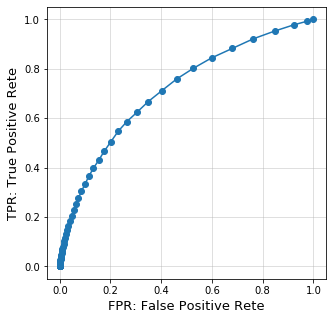

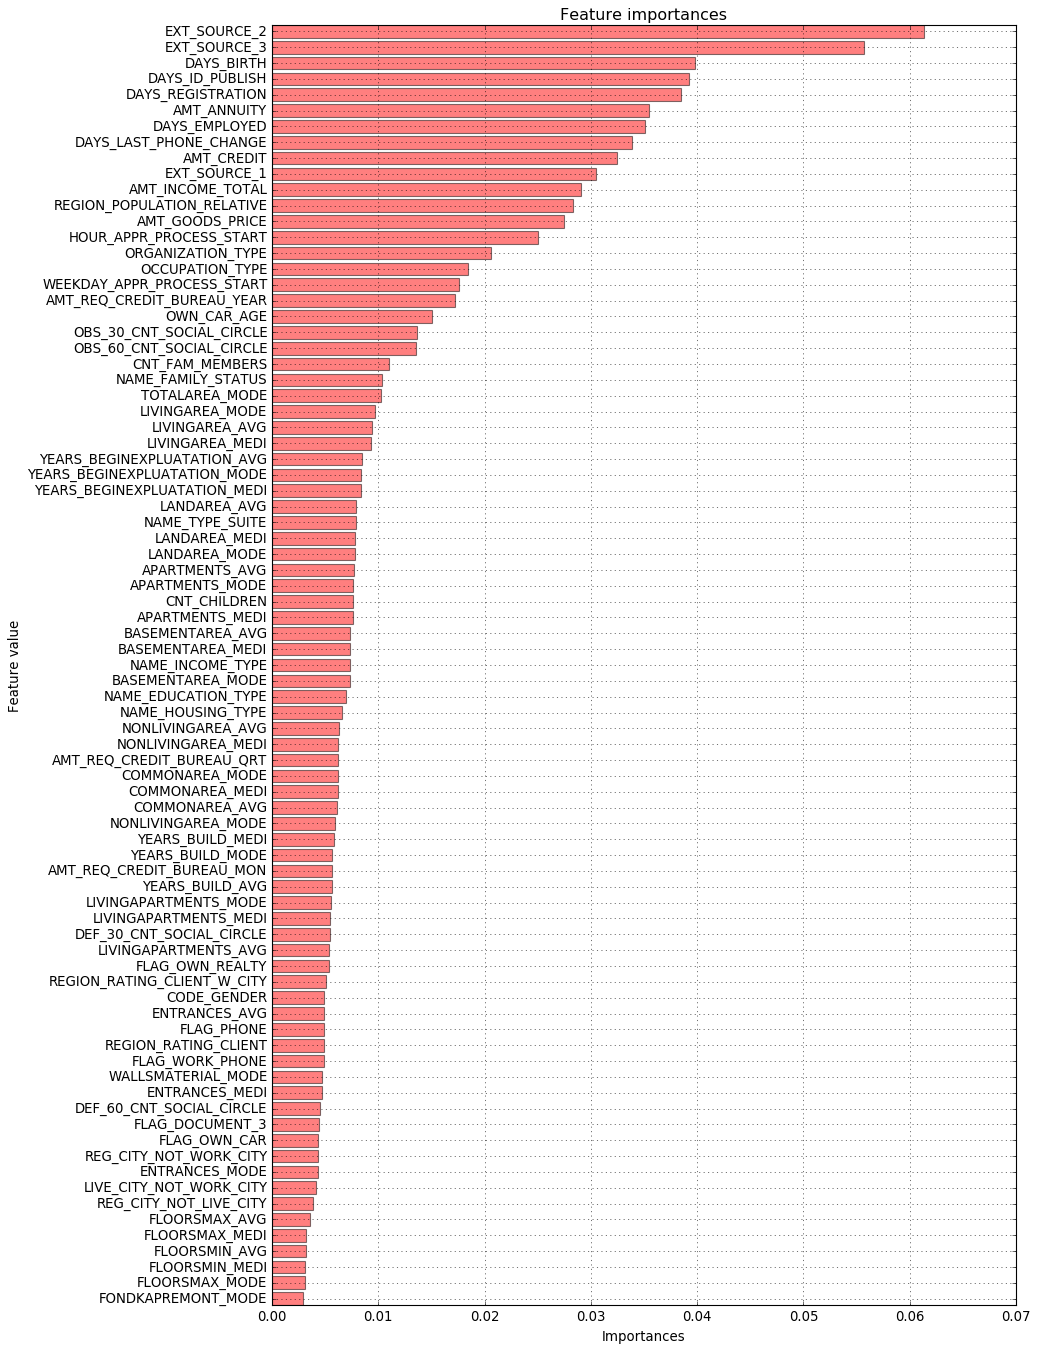

In [30]:
model04, y_pred04, importances04 = classification_model(df4_3.drop('SK_ID_CURR', axis=1), 
                                         'TARGET', 
                                         algorithm='RandomForestClassifier', 
                                         roc=True, 
                                         confusion=False,
                                         standardization=False)

## ■パターン3の結論
重要度の累計95%以下までは、除外するとややAUCが上昇した。

それ以上除外すると、AUCが悪化する様子。

## ★★★★★★★★ パターン4 ★★★★★★★★
パターン3から、重要度が低すぎる特徴量は学習に悪影響を与えるため除外した方が良いと言える。

そのため、パターン3で除外した特徴量を、これまでで最も精度が高かったパターン2から除外して学習する。

## ■不要な特徴量の除外

In [31]:
# パターン2で使用したデータフラームを別名コピー
df4_4 = df4_2.copy()
df4_4.shape

(307511, 79)

In [32]:
# パターン3で除外した特徴量を取得
drop_idx4_4 = list(imp_ruikei80[imp_ruikei80 > cut_ratio].index)

In [33]:
# パターン2のデータから上記特徴量を除外
for drop_column in drop_idx4_4:
    if drop_column in list(df4_4.columns):
        df4_4.drop(drop_column, axis=1, inplace=True)
df4_4.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EXT_SOURCE_1,OWN_CAR_AGE
0,100002,1,1,0,0,0,202500.0,406597.5,24700.5,351000.0,...,2.0,2.0,2.0,-1134.0,1,0.0,0.0,1.0,0.083037,9.0
1,100003,0,0,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,0.0,1.0,0.0,-828.0,1,0.0,0.0,0.0,0.311267,9.0
2,100004,0,1,1,0,0,67500.0,135000.0,6750.0,135000.0,...,0.0,0.0,0.0,-815.0,0,0.0,0.0,0.0,0.505998,26.0
3,100006,0,0,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,2.0,0.0,-617.0,1,0.0,0.0,1.0,0.505998,9.0
4,100007,0,1,0,0,0,121500.0,513000.0,21865.5,513000.0,...,0.0,0.0,0.0,-1106.0,0,0.0,0.0,0.0,0.505998,9.0


In [34]:
df4_4.shape

(307511, 47)

## モデル作成

[INFO] Running train_test_spolit (test_size = 0.3,  random_state = 0)
[INFO] Running RandomForestClassifier...
[INFO] RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
[INFO] auc: 0.7193426676799909


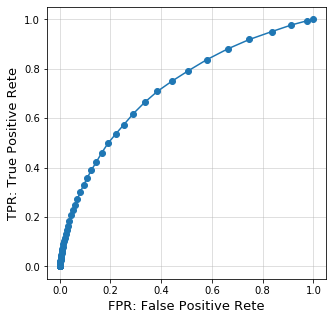

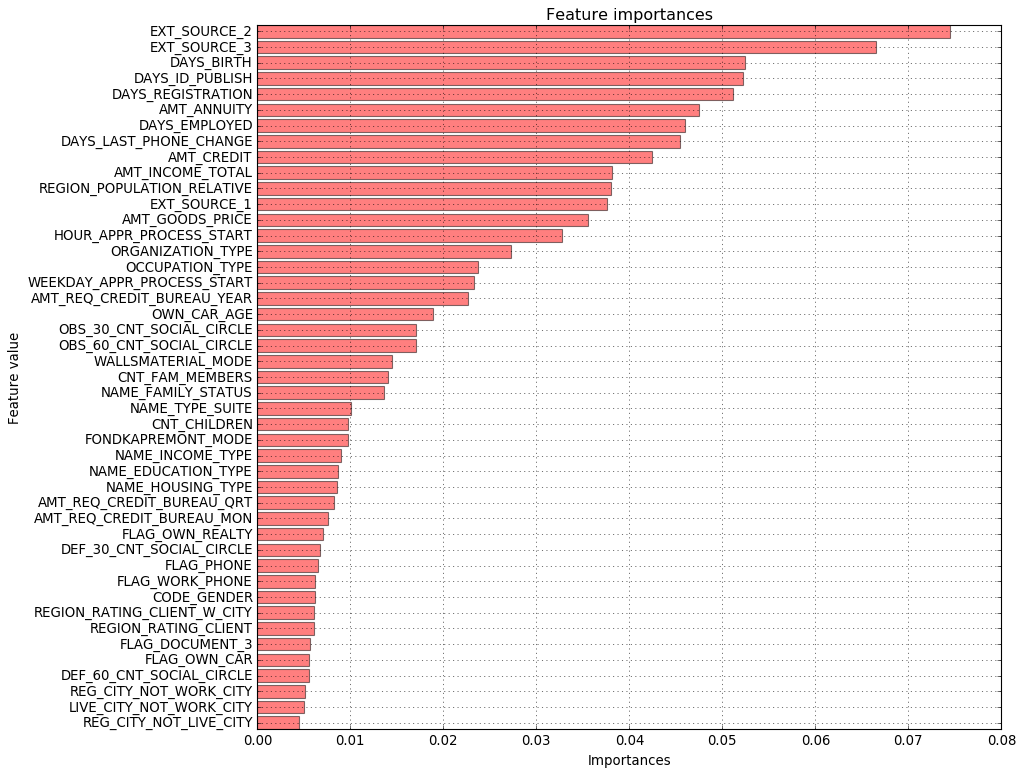

In [35]:
model05, y_pred05, importances05 = classification_model(df4_4.drop('SK_ID_CURR', axis=1), 
                                         'TARGET', 
                                         algorithm='RandomForestClassifier', 
                                         roc=True, 
                                         confusion=False,
                                         standardization=False)

## パターン4の結論

パターン2からの大きな変化は見られなかった。

## ★★★★★★★★ パターン5 ★★★★★★★★

パターン4の変数間の相関を確認して、相関が高いものを除外する。


## ■相関係数の確認

In [36]:
# 相関行列ヒートマップ
def corr_heatmap(df, annot=False):
    correlation_train=df.corr()
    plt.figure(figsize = (50,35))
#     sns.set(font_scale=2)
    if annot:
        ax = sns.heatmap(correlation_train, annot=True,annot_kws={"size": 20},fmt='.1f',cmap='PiYG', linewidths=.5)
    else:
        ax = sns.heatmap(correlation_train,cmap='PiYG', linewidths=.5)
    plt.show()

# corr_heatmap(df4_4, annot=True)

■正の相関
- CNT_FAM_MEMBERS - CNT_CHILDREN  :0.9
- AMT_ANNUITY - AMT_CREDIT  :0.8
- AMT_GOODS_PRICE - AMT_ANNUITY  :0.8
- DAYS_EMPLOYED - NAME_INCOME_TYPE  :0.6

■負の相関
- DAYS_EMPLOYED - DAYS_BIRTH  :-0.6
- REGION_RATING_CLIENT - REGION_POPULATION_RELATIVE  :-0.5
- REGION_RATING_CLIENT_W_CITY - REGION_POPULATION_RELATIVE  :-0.5

それぞれの重要度を調査

In [37]:
corr_columns = ['CNT_FAM_MEMBERS', 'CNT_CHILDREN',
                'AMT_ANNUITY', 'AMT_CREDIT',
                'AMT_GOODS_PRICE',
                'DAYS_EMPLOYED', 'NAME_INCOME_TYPE',
                'DAYS_BIRTH', 
                'REGION_RATING_CLIENT', 'REGION_POPULATION_RELATIVE', 
                'REGION_RATING_CLIENT_W_CITY']

importances05.loc[corr_columns]

CNT_FAM_MEMBERS                0.014102
CNT_CHILDREN                   0.009803
AMT_ANNUITY                    0.047491
AMT_CREDIT                     0.042402
AMT_GOODS_PRICE                0.035551
DAYS_EMPLOYED                  0.045995
NAME_INCOME_TYPE               0.008961
DAYS_BIRTH                     0.052402
REGION_RATING_CLIENT           0.006093
REGION_POPULATION_RELATIVE     0.037999
REGION_RATING_CLIENT_W_CITY    0.006115
dtype: float64

【確認結果】
- CNT_FAM_MEMBERS                0.014101 
- CNT_CHILDREN                   0.009652 ★除外
- AMT_ANNUITY                    0.047173 
- AMT_CREDIT                     0.043048 ★除外
- AMT_GOODS_PRICE                0.035747 ★除外
- DAYS_EMPLOYED                  0.045620
- NAME_INCOME_TYPE               0.009321 ★除外
- DAYS_BIRTH                     0.052758
- REGION_RATING_CLIENT           0.006039 ★除外
- REGION_POPULATION_RELATIVE     0.037582
- REGION_RATING_CLIENT_W_CITY    0.006259★除外

In [38]:
drop_col4_5 = ['CNT_CHILDREN', 'NAME_INCOME_TYPE',
               'DAYS_BIRTH', 
               'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']

df4_5 = df4_4.copy()
print(df4_5.shape)
df4_5.drop(drop_col4_5, axis=1, inplace=True)
print(df4_5.shape)

(307511, 47)
(307511, 42)


## ■モデル化

[INFO] Running train_test_spolit (test_size = 0.3,  random_state = 0)
[INFO] Running RandomForestClassifier...
[INFO] RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
[INFO] auc: 0.7210538524343816


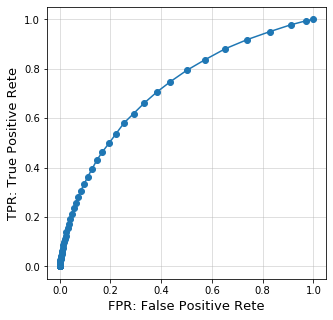

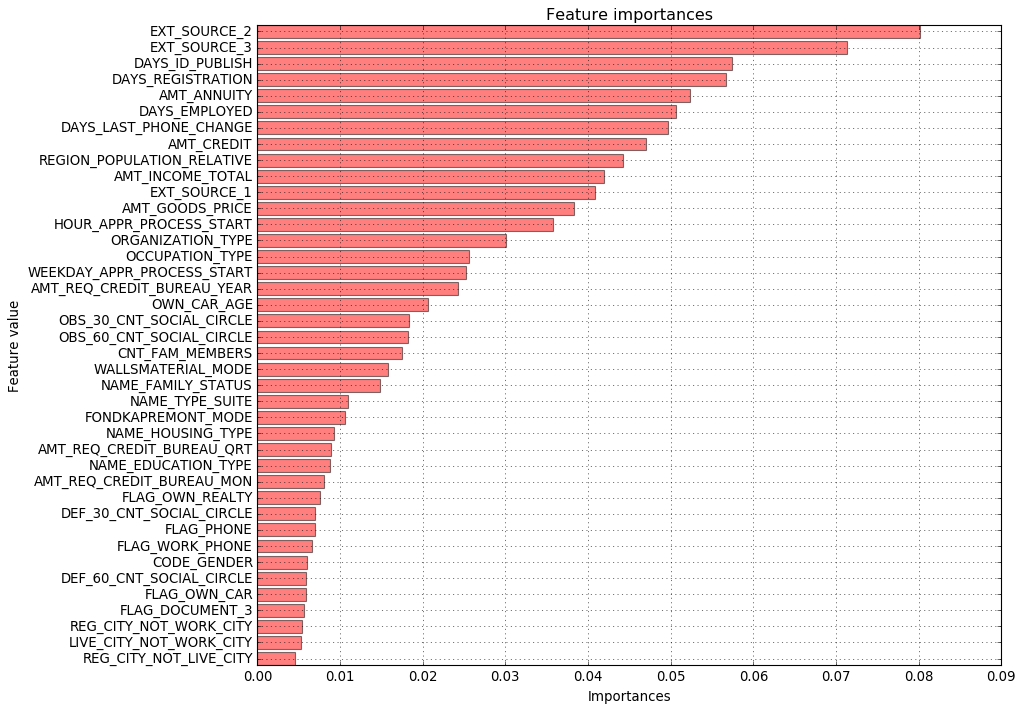

In [39]:
model06, y_pred06, importances06 = classification_model(df4_5.drop('SK_ID_CURR', axis=1), 
                                         'TARGET', 
                                         algorithm='RandomForestClassifier', 
                                         roc=True, 
                                         confusion=False,
                                         standardization=False)

## ★★★★★★★★ パターン6 ★★★★★★★★
データの対数変換やスケーリングを行う

## ■データの用意

In [40]:
df4_6 = df.loc[:, list(importances06.index)]
df4_6 = pd.concat([df4_6, df.loc[:,['SK_ID_CURR', 'TARGET']]], axis=1)
df4_6.head()

,REG_CITY_NOT_LIVE_CITY,LIVE_CITY_NOT_WORK_CITY,REG_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_3,FLAG_OWN_CAR,DEF_60_CNT_SOCIAL_CIRCLE,CODE_GENDER,FLAG_WORK_PHONE,FLAG_PHONE,DEF_30_CNT_SOCIAL_CIRCLE,...,AMT_CREDIT,DAYS_LAST_PHONE_CHANGE,DAYS_EMPLOYED,AMT_ANNUITY,DAYS_REGISTRATION,DAYS_ID_PUBLISH,EXT_SOURCE_3,EXT_SOURCE_2,SK_ID_CURR,TARGET
0,0,0,0,1,N,2.0,M,0,1,2.0,...,406597.5,-1134.0,-637,24700.5,-3648.0,-2120,0.139376,0.262949,100002,1
1,0,0,0,1,N,0.0,F,0,1,0.0,...,1293502.5,-828.0,-1188,35698.5,-1186.0,-291,NaN,0.622246,100003,0
2,0,0,0,0,Y,0.0,M,1,1,0.0,...,135000.0,-815.0,-225,6750.0,-4260.0,-2531,0.729567,0.555912,100004,0
3,0,0,0,1,N,0.0,F,0,0,0.0,...,312682.5,-617.0,-3039,29686.5,-9833.0,-2437,NaN,0.650442,100006,0
4,0,1,1,0,N,0.0,M,0,0,0.0,...,513000.0,-1106.0,-3038,21865.5,-4311.0,-3458,NaN,0.322738,100007,0


In [41]:
df4_6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 42 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   REG_CITY_NOT_LIVE_CITY      307511 non-null  int64  
 1   LIVE_CITY_NOT_WORK_CITY     307511 non-null  int64  
 2   REG_CITY_NOT_WORK_CITY      307511 non-null  int64  
 3   FLAG_DOCUMENT_3             307511 non-null  int64  
 4   FLAG_OWN_CAR                307511 non-null  object 
 5   DEF_60_CNT_SOCIAL_CIRCLE    306490 non-null  float64
 6   CODE_GENDER                 307511 non-null  object 
 7   FLAG_WORK_PHONE             307511 non-null  int64  
 8   FLAG_PHONE                  307511 non-null  int64  
 9   DEF_30_CNT_SOCIAL_CIRCLE    306490 non-null  float64
 10  FLAG_OWN_REALTY             307511 non-null  object 
 11  AMT_REQ_CREDIT_BUREAU_MON   265992 non-null  float64
 12  NAME_EDUCATION_TYPE         307511 non-null  object 
 13  AMT_REQ_CREDIT

## ■objectのデータの尺度を確認

In [42]:
def obj_value_counts(df):
    for column in df:
        if np.dtype(df[column]) == 'object':
            print('■', column)
            print(df[column].value_counts())
obj_value_counts(df4_6)
obj_df = df4_6.select_dtypes(include=object)

■ FLAG_OWN_CAR
N    202924
Y    104587
Name: FLAG_OWN_CAR, dtype: int64
■ CODE_GENDER
F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64
■ FLAG_OWN_REALTY
Y    213312
N     94199
Name: FLAG_OWN_REALTY, dtype: int64
■ NAME_EDUCATION_TYPE
Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: NAME_EDUCATION_TYPE, dtype: int64
■ NAME_HOUSING_TYPE
House / apartment      272868
With parents            14840
Municipal apartment     11183
Rented apartment         4881
Office apartment         2617
Co-op apartment          1122
Name: NAME_HOUSING_TYPE, dtype: int64
■ FONDKAPREMONT_MODE
reg oper account         73830
reg oper spec account    12080
not specified             5687
org spec account          5619
Name: FONDKAPREMONT_MODE, dtype: int64
■ NAME_TYPE_SUITE
Unaccompanied      248526
Family              40149
Spouse, 

### WEEKDAY_APPR_PROCESS_START　のみ順序に意味があるため月曜始まりで0~6に置換

In [43]:
weekday_map = {'MONDAY':0, 'TUESDAY':1, 'WEDNESDAY':2, 'THURSDAY':3, 'FRIDAY':4, 'SATURDAY':5, 'SUNDAY':6}
df4_6['WEEKDAY_APPR_PROCESS_START'] = df4_6['WEEKDAY_APPR_PROCESS_START'].map(weekday_map)
df4_6['WEEKDAY_APPR_PROCESS_START'].value_counts()

1    53901
2    51934
0    50714
3    50591
4    50338
5    33852
6    16181
Name: WEEKDAY_APPR_PROCESS_START, dtype: int64

### その他のobject型の変数は全て数値化する。

※欠損がある特徴量もあるが、欠損率がやや高く、ランダム値等では埋められないためnan=0のように置換する

In [44]:
print("カテゴリ変数を以下のように置換")
df4_6 = dummy_variable_all(df4_6, dropna=False, map_show=True, skip_column=['WEEKDAY_APPR_PROCESS_START'])

カテゴリ変数を以下のように置換
column_name : FLAG_OWN_CAR
replace : {'N': 0, 'Y': 1}
column_name : CODE_GENDER
replace : {'F': 0, 'M': 1, 'XNA': 2}
column_name : FLAG_OWN_REALTY
replace : {'Y': 0, 'N': 1}
column_name : NAME_EDUCATION_TYPE
replace : {'Secondary / secondary special': 0, 'Higher education': 1, 'Incomplete higher': 2, 'Lower secondary': 3, 'Academic degree': 4}
column_name : NAME_HOUSING_TYPE
replace : {'House / apartment': 0, 'With parents': 1, 'Municipal apartment': 2, 'Rented apartment': 3, 'Office apartment': 4, 'Co-op apartment': 5}
column_name : FONDKAPREMONT_MODE
replace : {nan: 0, 'reg oper account': 1, 'reg oper spec account': 2, 'not specified': 3, 'org spec account': 4}
column_name : NAME_TYPE_SUITE
replace : {'Unaccompanied': 0, 'Family': 1, 'Spouse, partner': 2, 'Children': 3, 'Other_B': 4, nan: 5, 'Other_A': 6, 'Group of people': 7}
column_name : NAME_FAMILY_STATUS
replace : {'Married': 0, 'Single / not married': 1, 'Civil marriage': 2, 'Separated': 3, 'Widow': 4, 'Unknown'

## 全特徴量の分布を可視化

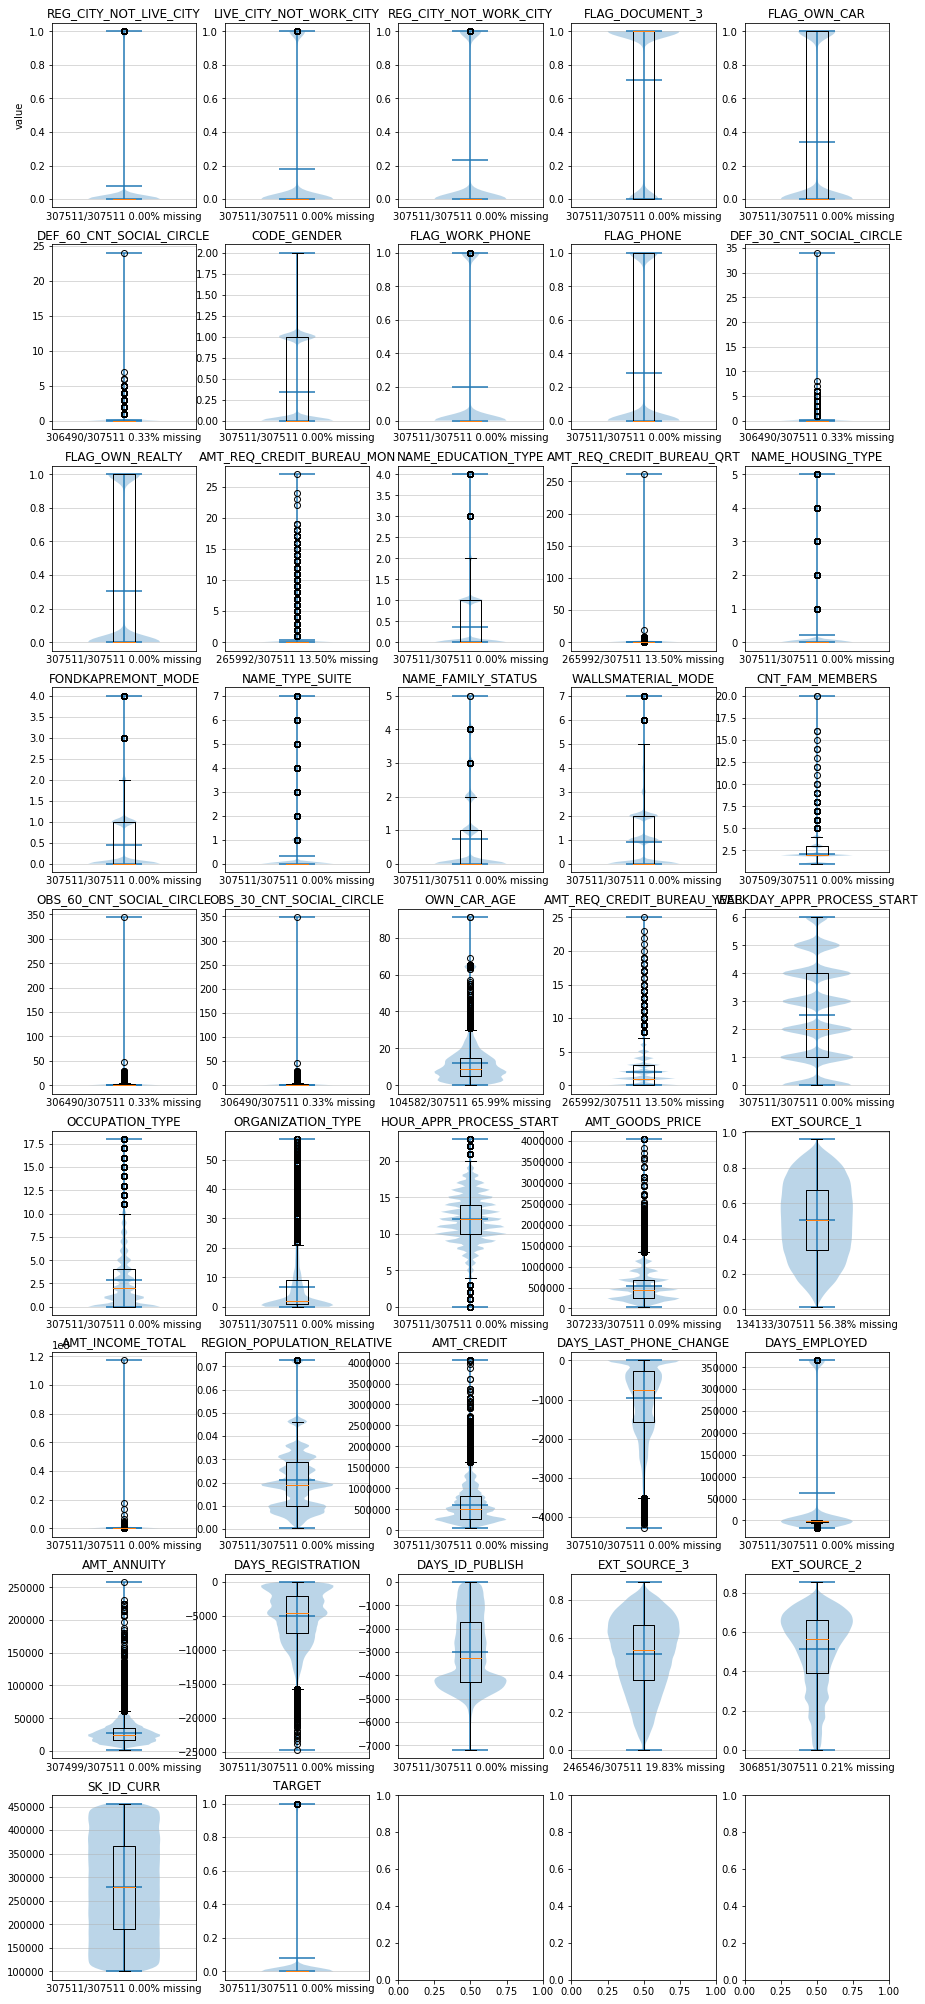

In [45]:
box_violin(df4_6, box=True, violin=True)

## ロングテールになっているデータを対数変換する

In [46]:
# 対象のカラム名をリスト化
long_columns = ['OWN_CAR_AGE', 'AMT_CREDIT', 'AMT_ANNUITY']

In [47]:
# ヒストグラム一括表示
def hist_show(df):
    
    n2 = 3
    n1 = int(np.ceil(df.shape[1]/n2))
    
    fig, axes = plt.subplots(n1, n2, figsize=(15, n1*4))
    ax = axes.ravel()
        
    for i, column_name in enumerate(df):
        ax[i].hist(df[column_name].dropna(), bins=30)
        # グラフ設定
        ax[i].set_title(column_name)
        ax[i].grid(True, alpha=0.6)
    
    ax[0].set_ylabel('Frequence')
    plt.show()

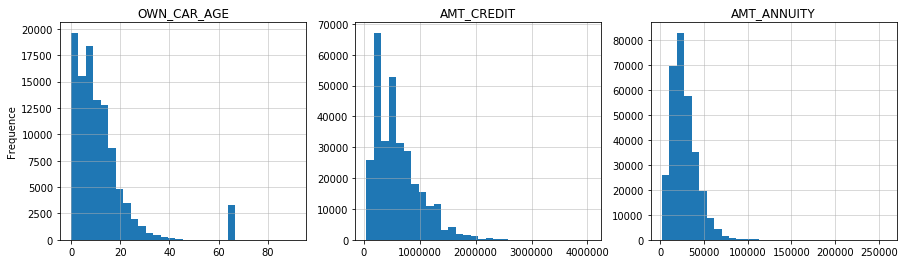

In [48]:
hist_show(df4_6.loc[:, long_columns])

In [49]:
def change(df):
    long_columns = ['OWN_CAR_AGE', 'AMT_CREDIT', 'AMT_ANNUITY']
    df_tmp = df.loc[:, long_columns].apply(np.log1p)
    for i in df_tmp:
        df[i] = df_tmp[i]
        
change(df4_6)
df4_6.head()

,REG_CITY_NOT_LIVE_CITY,LIVE_CITY_NOT_WORK_CITY,REG_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_3,FLAG_OWN_CAR,DEF_60_CNT_SOCIAL_CIRCLE,CODE_GENDER,FLAG_WORK_PHONE,FLAG_PHONE,DEF_30_CNT_SOCIAL_CIRCLE,...,AMT_CREDIT,DAYS_LAST_PHONE_CHANGE,DAYS_EMPLOYED,AMT_ANNUITY,DAYS_REGISTRATION,DAYS_ID_PUBLISH,EXT_SOURCE_3,EXT_SOURCE_2,SK_ID_CURR,TARGET
0,0,0,0,1,0,2.0,1,0,1,2.0,...,12.915581,-1134.0,-637,10.114619,-3648.0,-2120,0.139376,0.262949,100002,1
1,0,0,0,1,0,0.0,0,0,1,0.0,...,14.072865,-828.0,-1188,10.482892,-1186.0,-291,NaN,0.622246,100003,0
2,0,0,0,0,1,0.0,1,1,1,0.0,...,11.813037,-815.0,-225,8.817446,-4260.0,-2531,0.729567,0.555912,100004,0
3,0,0,0,1,0,0.0,0,0,0,0.0,...,12.652947,-617.0,-3039,10.298481,-9833.0,-2437,NaN,0.650442,100006,0
4,0,1,1,0,0,0.0,1,0,0,0.0,...,13.148033,-1106.0,-3038,9.992711,-4311.0,-3458,NaN,0.322738,100007,0


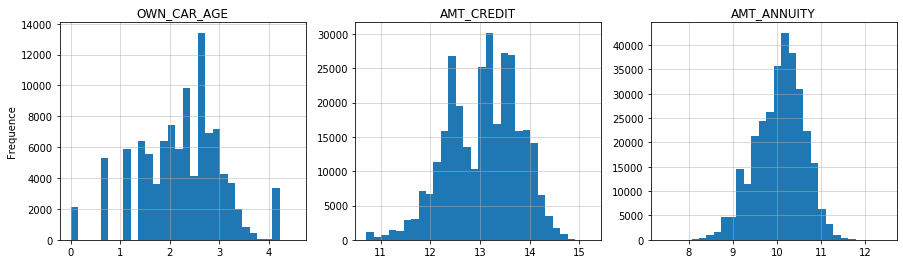

In [50]:
hist_show(df4_6.loc[:, long_columns])

## スケーリング用関数を用意
モデル実行時に引数として渡す関数を用意

連続データは標準化、その他のデータは0~1に正規化する

In [51]:
# スケーリング用の関数用意
def scaling_func(x_train, x_test):
    # 連続データ取得
    num_columns = x_train.columns[x_train.max() > 10]
    num_columns.append(x_train.columns[x_train.min() < 0])
    
    # 連続データを標準化
    scaler = StandardScaler()
    scaler.fit(x_train.loc[:, num_columns])
    x_train.loc[:, num_columns] = scaler.transform(x_train.loc[:, num_columns])
    x_test.loc[:, num_columns] = scaler.transform(x_test.loc[:, num_columns])
    
    # min-maxスケーリング
    cat_columns = [i for i in x_train.columns if i not in num_columns]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(x_train.loc[:, cat_columns])
    x_train.loc[:, cat_columns] = scaler.transform(x_train.loc[:, cat_columns])
    x_test.loc[:, cat_columns] = scaler.transform(x_test.loc[:, cat_columns])


## 欠損値の穴埋め

大きな偏りは対数変換で調整したため、今回は平均値で穴埋めする。

In [52]:
df4_6 = df4_6.fillna(df4_6.mean())
df4_6.isnull().sum()

REG_CITY_NOT_LIVE_CITY        0
LIVE_CITY_NOT_WORK_CITY       0
REG_CITY_NOT_WORK_CITY        0
FLAG_DOCUMENT_3               0
FLAG_OWN_CAR                  0
DEF_60_CNT_SOCIAL_CIRCLE      0
CODE_GENDER                   0
FLAG_WORK_PHONE               0
FLAG_PHONE                    0
DEF_30_CNT_SOCIAL_CIRCLE      0
FLAG_OWN_REALTY               0
AMT_REQ_CREDIT_BUREAU_MON     0
NAME_EDUCATION_TYPE           0
AMT_REQ_CREDIT_BUREAU_QRT     0
NAME_HOUSING_TYPE             0
FONDKAPREMONT_MODE            0
NAME_TYPE_SUITE               0
NAME_FAMILY_STATUS            0
WALLSMATERIAL_MODE            0
CNT_FAM_MEMBERS               0
OBS_60_CNT_SOCIAL_CIRCLE      0
OBS_30_CNT_SOCIAL_CIRCLE      0
OWN_CAR_AGE                   0
AMT_REQ_CREDIT_BUREAU_YEAR    0
WEEKDAY_APPR_PROCESS_START    0
OCCUPATION_TYPE               0
ORGANIZATION_TYPE             0
HOUR_APPR_PROCESS_START       0
AMT_GOODS_PRICE               0
EXT_SOURCE_1                  0
AMT_INCOME_TOTAL              0
REGION_P

## ■モデル作成

[INFO] Running train_test_spolit (test_size = 0.3,  random_state = 0)
[INFO] Running custom scaling function...


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

[INFO] Running RandomForestClassifier...
[INFO] RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
[INFO] auc: 0.7199112690968179


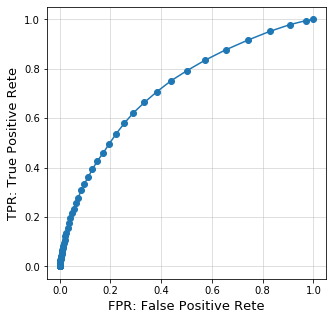

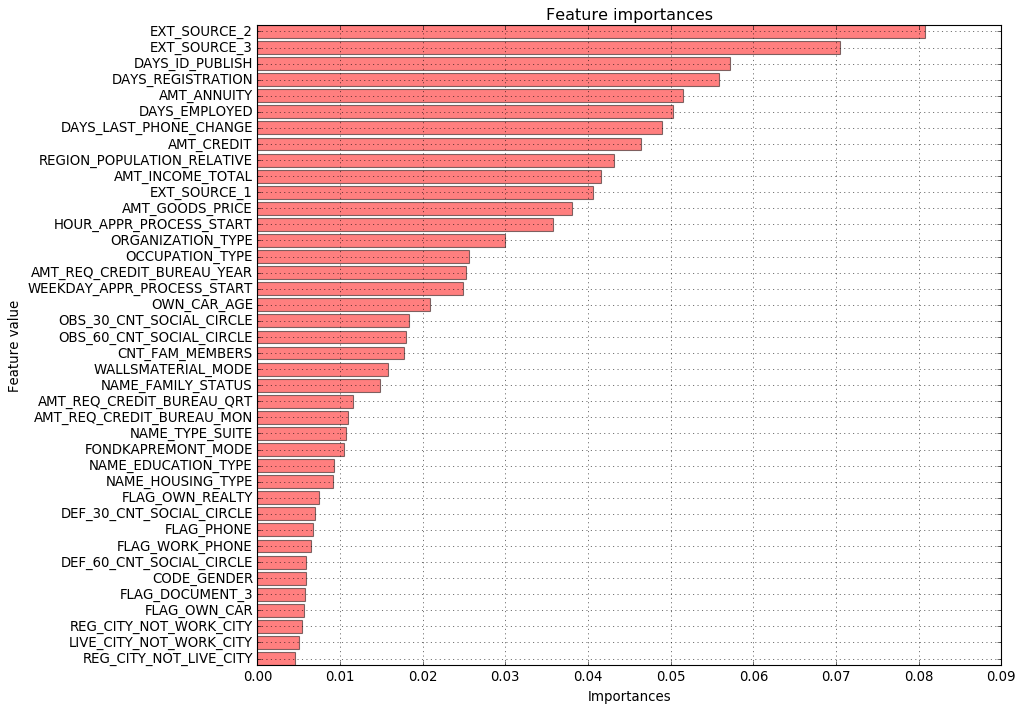

In [53]:
model07, y_pred07, importances07 = classification_model(df4_6.drop('SK_ID_CURR', axis=1), 
                                         'TARGET', 
                                         algorithm='RandomForestClassifier', 
                                         roc=True, 
                                         confusion=False,
                                         standardization=False,
                                         scaling_func=scaling_func)

## パターン6結論
少しだけ精度が上がった気がするが、大きな変化はなかった。

# パターン6でKaggle再提出

In [54]:
a = list(importances06.index)
a.append('TARGET')
a

['REG_CITY_NOT_LIVE_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'FLAG_DOCUMENT_3',
 'FLAG_OWN_CAR',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'CODE_GENDER',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'FLAG_OWN_REALTY',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'NAME_EDUCATION_TYPE',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'NAME_HOUSING_TYPE',
 'FONDKAPREMONT_MODE',
 'NAME_TYPE_SUITE',
 'NAME_FAMILY_STATUS',
 'WALLSMATERIAL_MODE',
 'CNT_FAM_MEMBERS',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'OWN_CAR_AGE',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'WEEKDAY_APPR_PROCESS_START',
 'OCCUPATION_TYPE',
 'ORGANIZATION_TYPE',
 'HOUR_APPR_PROCESS_START',
 'AMT_GOODS_PRICE',
 'EXT_SOURCE_1',
 'AMT_INCOME_TOTAL',
 'REGION_POPULATION_RELATIVE',
 'AMT_CREDIT',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_EMPLOYED',
 'AMT_ANNUITY',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'TARGET']

In [55]:
a = list(importances06.index)
a.append('SK_ID_CURR')
df_test02 = df_test02.loc[:, a]

In [56]:
df_test02_id = df_test02.loc[:, ['SK_ID_CURR']]
df_test02.drop('SK_ID_CURR', axis=1, inplace=True)
df_test02.head()

,REG_CITY_NOT_LIVE_CITY,LIVE_CITY_NOT_WORK_CITY,REG_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_3,FLAG_OWN_CAR,DEF_60_CNT_SOCIAL_CIRCLE,CODE_GENDER,FLAG_WORK_PHONE,FLAG_PHONE,DEF_30_CNT_SOCIAL_CIRCLE,...,AMT_INCOME_TOTAL,REGION_POPULATION_RELATIVE,AMT_CREDIT,DAYS_LAST_PHONE_CHANGE,DAYS_EMPLOYED,AMT_ANNUITY,DAYS_REGISTRATION,DAYS_ID_PUBLISH,EXT_SOURCE_3,EXT_SOURCE_2
0,0,0,0,1,N,0.0,F,0,0,0.0,...,135000.0,0.018850,568800.0,-1740.0,-2329,20560.5,-5170.0,-812,0.159520,0.789654
1,0,0,0,1,N,0.0,M,0,0,0.0,...,99000.0,0.035792,222768.0,0.0,-4469,17370.0,-9118.0,-1623,0.432962,0.291656
2,0,0,0,0,Y,0.0,M,0,0,0.0,...,202500.0,0.019101,663264.0,-856.0,-4458,69777.0,-2175.0,-3503,0.610991,0.699787
3,0,0,0,1,N,0.0,F,0,1,0.0,...,315000.0,0.026392,1575000.0,-1805.0,-1866,49018.5,-2000.0,-4208,0.612704,0.509677
4,0,1,1,1,Y,0.0,M,1,0,0.0,...,180000.0,0.010032,625500.0,-821.0,-2191,32067.0,-4000.0,-4262,NaN,0.425687


In [57]:
def preprocessing(df):
    # 曜日を変換
    weekday_map = {'MONDAY':0, 'TUESDAY':1, 'WEDNESDAY':2, 'THURSDAY':3, 'FRIDAY':4, 'SATURDAY':5, 'SUNDAY':6}
    df['WEEKDAY_APPR_PROCESS_START'] = df['WEEKDAY_APPR_PROCESS_START'].map(weekday_map)

    # カテゴリデータ一括置換
    df = dummy_variable_all(df, dropna=False, map_show=False, skip_column=['WEEKDAY_APPR_PROCESS_START'])

    # 対数変換
    change(df)

    # 欠損値を平均で埋める
    df = df.fillna(df.mean())
    return df

In [58]:
df_test02 = preprocessing(df_test02)

In [59]:
df_test02.head()

,REG_CITY_NOT_LIVE_CITY,LIVE_CITY_NOT_WORK_CITY,REG_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_3,FLAG_OWN_CAR,DEF_60_CNT_SOCIAL_CIRCLE,CODE_GENDER,FLAG_WORK_PHONE,FLAG_PHONE,DEF_30_CNT_SOCIAL_CIRCLE,...,AMT_INCOME_TOTAL,REGION_POPULATION_RELATIVE,AMT_CREDIT,DAYS_LAST_PHONE_CHANGE,DAYS_EMPLOYED,AMT_ANNUITY,DAYS_REGISTRATION,DAYS_ID_PUBLISH,EXT_SOURCE_3,EXT_SOURCE_2
0,0,0,0,1,0,0.0,0,0,0,0.0,...,135000.0,0.018850,13.251286,-1740.0,-2329,9.931176,-5170.0,-812,0.159520,0.789654
1,0,0,0,1,0,0.0,1,0,0,0.0,...,99000.0,0.035792,12.313891,0.0,-4469,9.762557,-9118.0,-1623,0.432962,0.291656
2,0,0,0,0,1,0.0,1,0,0,0.0,...,202500.0,0.019101,13.404930,-856.0,-4458,11.153074,-2175.0,-3503,0.610991,0.699787
3,0,0,0,1,0,0.0,0,0,1,0.0,...,315000.0,0.026392,14.269766,-1805.0,-1866,10.799973,-2000.0,-4208,0.612704,0.509677
4,0,1,1,1,1,0.0,1,1,0,0.0,...,180000.0,0.010032,13.346308,-821.0,-2191,10.375614,-4000.0,-4262,0.500106,0.425687


In [60]:
df_test02.isnull().sum()

REG_CITY_NOT_LIVE_CITY        0
LIVE_CITY_NOT_WORK_CITY       0
REG_CITY_NOT_WORK_CITY        0
FLAG_DOCUMENT_3               0
FLAG_OWN_CAR                  0
DEF_60_CNT_SOCIAL_CIRCLE      0
CODE_GENDER                   0
FLAG_WORK_PHONE               0
FLAG_PHONE                    0
DEF_30_CNT_SOCIAL_CIRCLE      0
FLAG_OWN_REALTY               0
AMT_REQ_CREDIT_BUREAU_MON     0
NAME_EDUCATION_TYPE           0
AMT_REQ_CREDIT_BUREAU_QRT     0
NAME_HOUSING_TYPE             0
FONDKAPREMONT_MODE            0
NAME_TYPE_SUITE               0
NAME_FAMILY_STATUS            0
WALLSMATERIAL_MODE            0
CNT_FAM_MEMBERS               0
OBS_60_CNT_SOCIAL_CIRCLE      0
OBS_30_CNT_SOCIAL_CIRCLE      0
OWN_CAR_AGE                   0
AMT_REQ_CREDIT_BUREAU_YEAR    0
WEEKDAY_APPR_PROCESS_START    0
OCCUPATION_TYPE               0
ORGANIZATION_TYPE             0
HOUR_APPR_PROCESS_START       0
AMT_GOODS_PRICE               0
EXT_SOURCE_1                  0
AMT_INCOME_TOTAL              0
REGION_P

In [61]:
df_test02['WEEKDAY_APPR_PROCESS_START']

0        1
1        4
2        0
3        2
4        4
        ..
48739    2
48740    0
48741    2
48742    0
48743    1
Name: WEEKDAY_APPR_PROCESS_START, Length: 48744, dtype: int64

In [62]:
predict07 = model07.predict_proba(df_test02)
df_test02_id['TARGET'] = predict07[:, 1]
df_test02_id.to_csv('./submission07.csv', index=False)

## Kaggleへの提出結果

Private Score : 0.62502

Public Score : 0.62737

スコアが落ちた...orz

## パターン5でKaggleへ提出

In [64]:
def preprocessing02(df):
    # カテゴリデータ一括置換
    df = dummy_variable_all(df, dropna=False, map_show=False)

    # 欠損値を平均で埋める
    df = df.fillna(df.median())
    return df

In [65]:
df_test03 = preprocessing02(df_test03)
df_test03 = df_test03.loc[:, list(df4_5.drop(['SK_ID_CURR', 'TARGET'], axis=1).columns)]
df_test03.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EXT_SOURCE_1,OWN_CAR_AGE
0,0,0,0,135000.0,568800.0,20560.5,450000.0,0,1,0,...,0.0,0.0,0.0,-1740.0,1,0.0,0.0,0.0,0.752614,9.0
1,1,0,0,99000.0,222768.0,17370.0,180000.0,0,0,0,...,0.0,0.0,0.0,0.0,1,0.0,0.0,3.0,0.564990,9.0
2,1,1,0,202500.0,663264.0,69777.0,630000.0,3,1,0,...,0.0,0.0,0.0,-856.0,0,0.0,1.0,4.0,0.506771,5.0
3,0,0,0,315000.0,1575000.0,49018.5,1575000.0,0,0,0,...,0.0,0.0,0.0,-1805.0,1,0.0,0.0,3.0,0.525734,9.0
4,1,1,1,180000.0,625500.0,32067.0,625500.0,0,0,0,...,0.0,0.0,0.0,-821.0,1,0.0,0.0,2.0,0.202145,16.0


In [66]:
predict06 = model06.predict_proba(df_test03)
df_test02_id['TARGET'] = predict06[:, 1]
df_test02_id.to_csv('./submission06.csv', index=False)

## Kaggleへの提出結果
Private Score : 0.70204

Public Score : 0.69648

ベースラインモデルよりやや上昇した。